In [7]:
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

from cloudbandpy.tracking import plot_tracking_on_map
from cloudbandpy.io_utilities import load_ymlfile, load_list, subset_latitudes, subset_longitudes
from cloudbandpy.time_utilities import create_list_of_dates, add_startend_datetime2config

#### Load configuration file and make adjustements for this test case

In [8]:
config_file = "../config/config_analysis.yml"
config = load_ymlfile(config_file, isconfigfile=True)
# Make sure that the period for the cloud bands cover the same period as the example data
config["startdate"] = "20210219.00"
config["enddate"] = "20210228.00"
dirdata= "../data/"
config["saved_dirpath"] = dirdata

filepath = f"{config['saved_dirpath']}list_of_cloud_bands"+config['startdate']+"-"+config['enddate']+"-"+config['domain']+".bin"
print("Example data exists:", os.path.isfile(filepath))
print("file is:", filepath)

2023-07-05 17:41:34,963 - io_utilities.load_ymlfile - INFO: Configuration file loaded


Example data exists: True
file is: ../data/list_of_cloud_bands20210219.00-20210228.00-southPacific.bin


#### Load cloud bands from the South Pacific for the dates specified in the analyses config file

In [9]:
add_startend_datetime2config(config)
listofdates = create_list_of_dates(config)
print(str(len(listofdates))+" dates created from "+str(listofdates[0])+" to "+str(listofdates[-1]))

10 dates created from 2021-02-19 00:00:00 to 2021-02-28 00:00:00


In [10]:
# Load one year of cloud bands
list_of_cloud_bands = load_list(filepath)
print(len(list_of_cloud_bands),"days of cloud bands")

10 days of cloud bands


#### Import longitudes and latitudes for the map

In [11]:
lons_globe = np.arange(0,360,.5)
lats_globe = np.arange(90,-90.5,-.5)
print(lats_globe.all()==lats_globe.all())
# Get longitudes and latitudes of South Pacific domain
_, lonsSP = subset_longitudes(lons_globe, config["lon_west"], config["lon_east"])
_, latsSP = subset_latitudes(lats_globe, config["lat_north"], config["lat_south"])

print(f"Longitudes, min: {lonsSP.min()}, max: {lonsSP.max()}")
print(f"Latitudes, min: {latsSP.min()}, max: {latsSP.max()}")

True
Longitudes, min: 130.0, max: 290.0
Latitudes, min: -50.0, max: 5.0


#### Create the series of map with connection lines between the centroid lcoation of each cloud bands

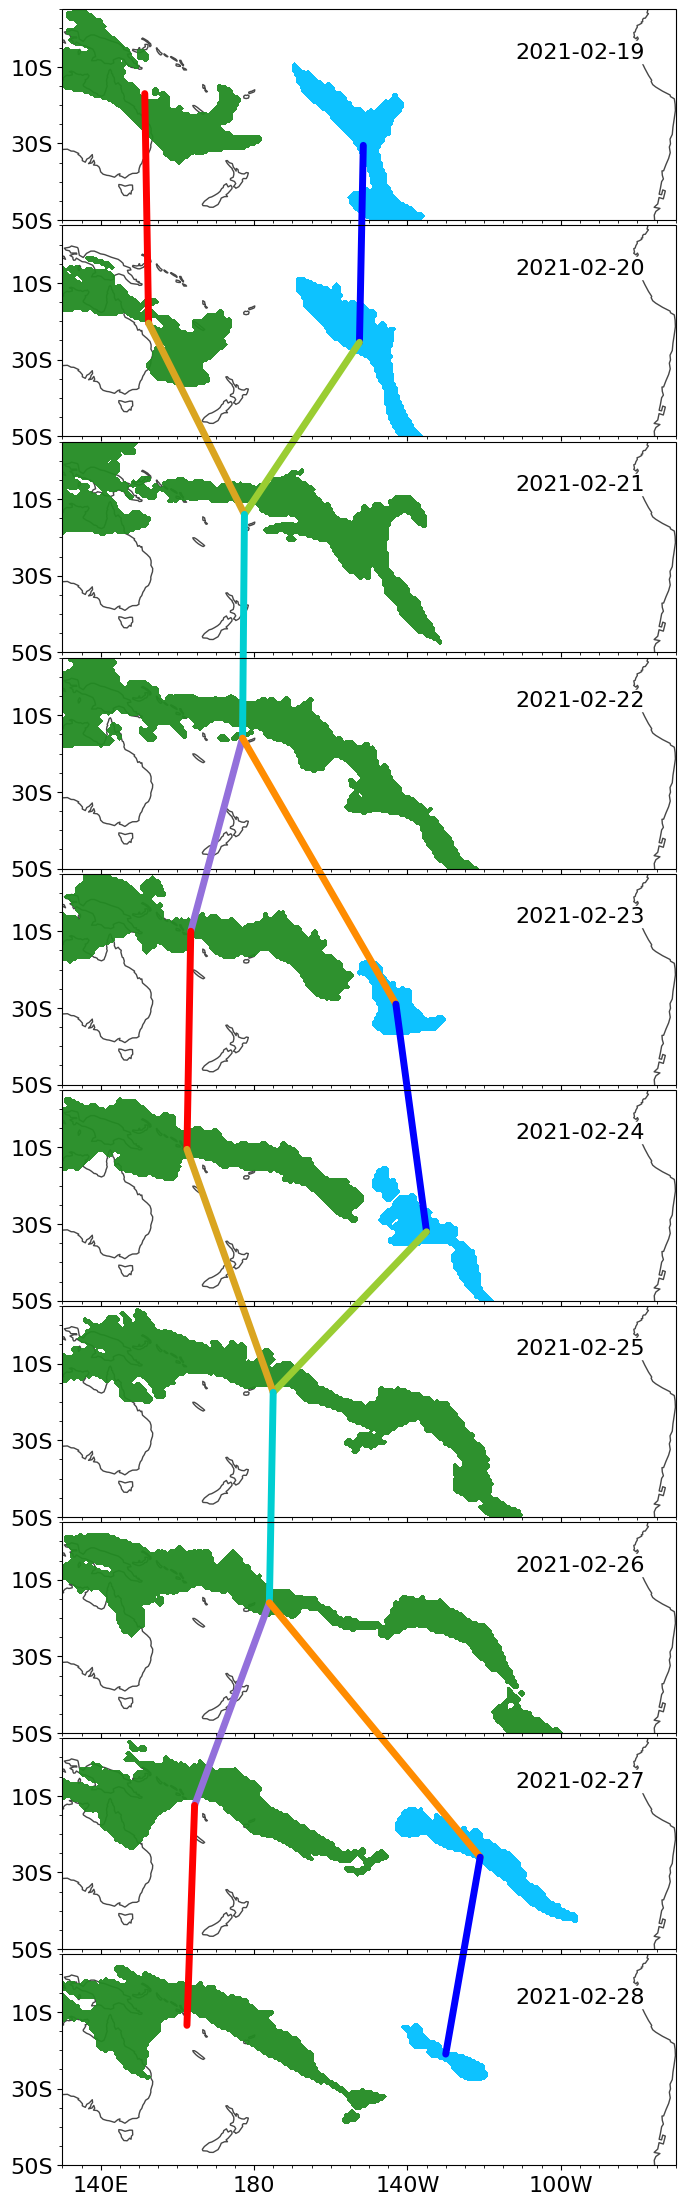

In [13]:
plot_tracking_on_map(
    list_of_cloud_bands=list_of_cloud_bands,
    lons=lonsSP,
    lats=latsSP,
    listofdates=listofdates,
    config=config,
    show=True,
    save=False,
)